In [69]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import sklearn.linear_model as lm
import seaborn as sns

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
import matplotlib.gridspec as gridspec
from sklearn.model_selection import train_test_split, KFold, LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier

# Plotting style
sns.set_style('darkgrid')
sns.set_theme(font_scale=1.)

# Define parameters
seed = 1234

In [70]:
# Initial data clean
df = pd.read_csv('data/SAHeart.csv')

# Encode Categorical values
df['chd'] = pd.Categorical(df['chd'])
df['famhist'] = df['famhist'].map({'Absent':0, 'Present':1}) #pd.Categorical(df['famhist'].map({'Absent':0, 'Present':1})) # One-of-K coding
# Filter outliers if we need to??
#df = df[~( (df[''] > 2) | (df[''] > 1) )]

df.head()

,row.names,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
0,1,160,12.00,5.73,23.11,1,49,25.30,97.20,52,1
1,2,144,0.01,4.41,28.61,0,55,28.87,2.06,63,1
2,3,118,0.08,3.48,32.28,1,52,29.14,3.81,46,0
3,4,170,7.50,6.41,38.03,1,51,31.99,24.26,58,1
4,5,134,13.60,3.50,27.78,1,60,25.99,57.34,49,1


In [71]:
# What to predict for Regression
X = df.drop(columns=['ldl', 'chd']).values
y = df['ldl'].values

N, M = X.shape


## 2 - Regularize

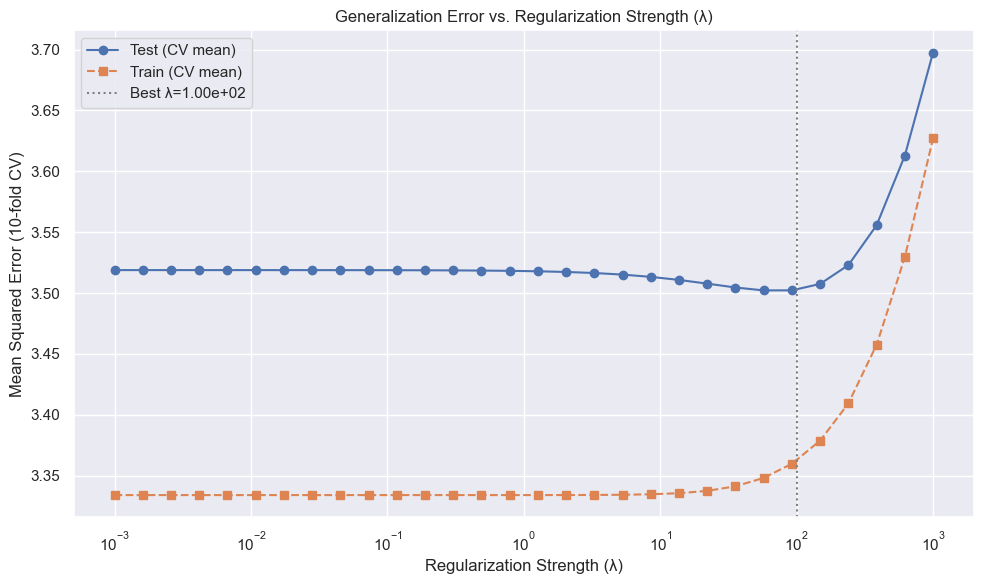

In [76]:
# Set random seed for reproducibility
np.random.seed(1234)

lambdas = np.logspace(-3, 3, 30)

# Create crossvalidation partition for hyperparameter tuning
K = 10
CV = KFold(K, shuffle=True, random_state=seed)

# Create a matrix to store results
train_errors = np.empty([len(lambdas), K])
test_errors = np.empty([len(lambdas), K])

# Train each model on different lambdas
for lambda_idx, regularization_strength in enumerate(lambdas):

    # Loop over inner folds
    for fold_idx, (train_index, test_index) in enumerate(CV.split(X, y)):

        # Split current inner fold into training and test set
        X_train, y_train = X[train_index], y[train_index]
        X_test, y_test = X[test_index], y[test_index]

        # Standardize inner training and validation sets
        mu = np.mean(X_train, axis=0)
        sigma = np.std(X_train, axis=0)
        sigma[sigma == 0] = 1.0

        X_train = (X_train - mu) / sigma
        X_test = (X_test - mu) / sigma

        model = Ridge(alpha=regularization_strength, fit_intercept = True, random_state=seed)
        model.fit(X_train, y_train)

        # Calculate error
        train_errors[lambda_idx, fold_idx] = np.mean((y_train - model.predict(X_train)) ** 2) 
        test_errors[lambda_idx, fold_idx] = np.mean((y_test - model.predict(X_test)) ** 2) 

mean_train = np.mean(train_errors, axis=1)
mean_test = np.mean(test_errors, axis=1)


plt.figure(figsize=(10,6))
plt.semilogx(lambdas, mean_test, marker='o', label='Test (CV mean)')
plt.semilogx(lambdas, mean_train, marker='s', linestyle='--', label='Train (CV mean)')
plt.axvline(best_lambda, color='gray', linestyle=':', label=f'Best λ={best_lambda:.2e}')
plt.title("Generalization Error vs. Regularization Strength (λ)")
plt.xlabel("Regularization Strength (λ)")
plt.ylabel("Mean Squared Error (10-fold CV)")
plt.legend()
plt.tight_layout()
plt.show()

We evaluated ridge regression with 10-fold cross-validation over regularization strengths λ ∈ [10⁻³, 10³].
The cross-validated mean squared error (MSE) curve showed the expected U-shaped pattern (Figure X).
For small λ, the model behaves like ordinary least squares and slightly overfits.
As λ increases, both training and test errors rise once the coefficients are excessively shrunk, indicating underfitting.
The optimal regularization strength was found around λ ≈ 10², which minimized the generalization error at approximately 3.5 MSE.
This suggests that moderate regularization improves model stability without sacrificing much accuracy.